# tmp — may24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 1
device = f'cuda:{device_idx}'

model_type = 'gaussian'

In [3]:
cfg_vae, cfg_tr = default_configs('DOVES', model_type, 'conv+b|lin')
cfg_vae['latent_act'] = 'exp'
cfg_vae['save'] = True
cfg_vae['seed'] = 665789

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [4]:
vae.cfg.name()

'gaussian_exp_DOVES_z-512_k-32_<conv+b|lin>_seed-665789'

In [12]:
vae.cfg.mods_dir

'/home/hadi/Projects/PoissonVAE/models/gaussian_exp_DOVES_z-512_k-32_<conv+b|lin>'

In [13]:
vae.create_chkpt_dir()

In [15]:
params = get_all_init_params(CFG_CLASSES[model_type])

In [16]:
params

{'self': <Parameter "self">,
 'kwargs': <Parameter "**kwargs">,
 'model_type': <Parameter "model_type: str">,
 'latent_act': <Parameter "latent_act: str = None">,
 'dataset': <Parameter "dataset: str">,
 'n_ch': <Parameter "n_ch: int = 32">,
 'n_latents': <Parameter "n_latents: int = 512">,
 'enc_type': <Parameter "enc_type: str = 'lin'">,
 'dec_type': <Parameter "dec_type: str = 'lin'">,
 'enc_bias': <Parameter "enc_bias: bool = False">,
 'dec_bias': <Parameter "dec_bias: bool = False">,
 'fit_prior': <Parameter "fit_prior: bool = False">,
 'weight_norm': <Parameter "weight_norm: bool = False">,
 'activation_fn': <Parameter "activation_fn: str = 'swish'">,
 'init_dist': <Parameter "init_dist: str = 'Normal'">,
 'init_scale': <Parameter "init_scale: float = 0.05">,
 'res_eps': <Parameter "res_eps: float = 1.0">,
 'use_bn': <Parameter "use_bn: bool = False">,
 'use_se': <Parameter "use_se: bool = True">,
 'seed': <Parameter "seed: int = 0">,
 'save': <Parameter "save: bool = True">,
 'd

In [ ]:
params

In [35]:
def aaa(obj, with_base=True):
    sig = inspect.signature(obj.__init__)
    params = dict(sig.parameters)
    if with_base:
        params.update(get_all_init_params(type(obj)))
    # get rid of self, args, kwargs
    vals = {
        k: getattr(obj, k) for
        k, p in params.items()
        if _param_checker(k, p, obj)
    }
    # get rid of functions
    vals = {
        k: v for k, v in vals.items()
        if not isinstance(v, Callable)
    }
    # remove directories
    vals = {
        k: v for k, v in vals.items()
        if '_dir' not in k
    }
    return vals

In [39]:
vals = aaa(CFG_CLASSES[model_type]) #(save=False, dataset='DOVES'))
vals

{}

In [37]:
def _param_checker(k, p, obj):
	# 2nd cond gets rid of args, kwargs
	return k != 'self' and int(p.kind) == 1 and hasattr(obj, k)

In [40]:
vals = aaa(vae.cfg)
vals

{'latent_act': 'exp',
 'dataset': 'DOVES',
 'n_ch': 32,
 'n_latents': 512,
 'enc_type': 'conv',
 'dec_type': 'lin',
 'enc_bias': True,
 'dec_bias': False,
 'fit_prior': False,
 'weight_norm': False,
 'activation_fn': 'swish',
 'init_dist': 'Normal',
 'init_scale': 0.05,
 'res_eps': 1.0,
 'use_bn': False,
 'use_se': True,
 'seed': 0}

In [4]:
root = add_home('Dropbox/chkpts/PoissonVAE')
name = 'poisson-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_11,02:31)'
tr, meta = load_quick(pjoin(root, name), True, device=device)

In [6]:
data, loss, etc = tr.validate()

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 134.43341, 'kl': 28.845055, 'kl_diag': 0.05582064, 'tot': 163.27847}

In [8]:
list(etc)

['log_dr', 'r*dr']

In [10]:
etc['r*dr'].shape

(28224, 512)

In [28]:
# i, j = 108, 45
i, j = np.unravel_index(np.argmax(data['z']), data['z'].shape)

etc['r*dr'][i, j], data['z'][i, j]

(10.544021, 22.0)

In [29]:
y = tr.model.decode(tr.to(etc['r*dr']))

In [33]:
mse = tr.model.loss_recon(y, tr.dl_vld.dataset.tensors[0])

In [35]:
mse.mean()

tensor(102.8239, device='cuda:1', grad_fn=<MeanBackward0>)

In [4]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [5]:
tr.train()

epoch # 1200, avg loss: 33.106931: 100%|██████████████████████| 1200/1200 [4:52:53<00:00, 14.64s/it]


In [3]:
tr, meta = load_model(
    'poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>',
    'init-both-scale0.1-df2+genlog_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_08,23:07)',
    device=device,
)
data, loss, etc = tr.validate()

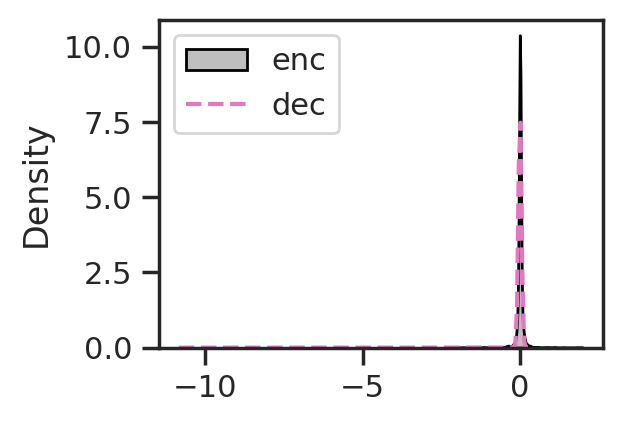

In [4]:
fig, ax= create_figure(dpi=200)
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
# ax.set(xlim=(-0.2, 0.2))
add_legend(ax)
plt.show()

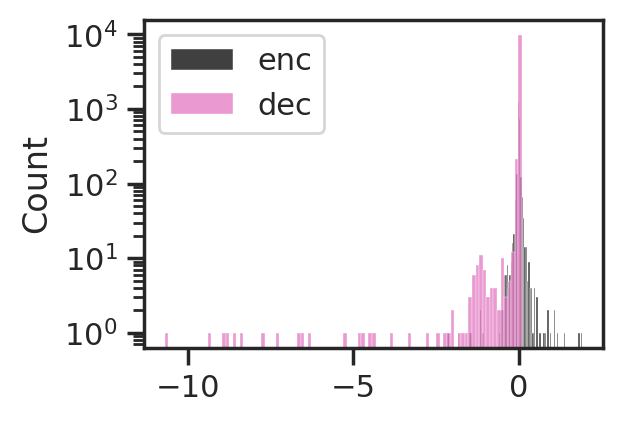

In [5]:
fig, ax= create_figure(dpi=200)
sns.histplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', bins=100, ax=ax)
sns.histplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', bins=100, ax=ax)
ax.set(yscale='log')
add_legend(ax)
plt.show()

In [6]:
from fitter import Fitter

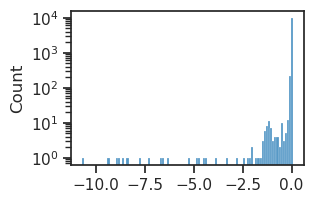

In [7]:
data = tonp(tr.model.fc_dec.weight).ravel()
ax = sns.histplot(data, bins=100)
ax.set_yscale('log')

In [8]:
f = Fitter(data, distributions=['genlogistic', 'logistic', 'laplace_asymmetric'], timeout=100000)
f.fit()

2024-05-09 03:17:46.209 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted logistic distribution with error=17.751625)
2024-05-09 03:17:46.238 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted laplace_asymmetric distribution with error=84.803)
2024-05-09 03:17:46.271 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted genlogistic distribution with error=85.759419)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
logistic,17.751625,50947.390455,50961.858569,inf,0.421723,0.0
laplace_asymmetric,84.803000,42187.823453,42209.525624,inf,0.718111,0.0
genlogistic,85.759419,38192.798228,38214.500399,inf,0.665229,0.0


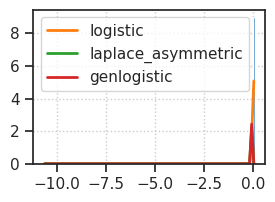

In [9]:
f.summary()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genlogistic,0.093783,33514.996285,33536.698455,inf,0.574685,0.0
laplace_asymmetric,0.208857,36381.606860,36403.309030,inf,0.602269,0.0
logistic,3.581498,47325.168234,47339.636347,inf,0.388869,0.0
loggamma,9.068392,24450.727119,24472.429290,inf,0.490801,0.0
laplace,11.191769,43644.004815,43658.472929,inf,0.356735,0.0


/home/hadi/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/hadi/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


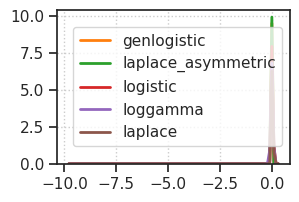

In [10]:
p_fitted = f.fitted_param['logistic']
print(p_fitted)

(-0.0004905928298628263, 0.020482593264335852)

In [11]:
p_hadi = (0.0, 0.02)

In [12]:
rv_fitted = sp_stats.logistic(*p_fitted)
rv_hadi = sp_stats.logistic(*p_hadi)

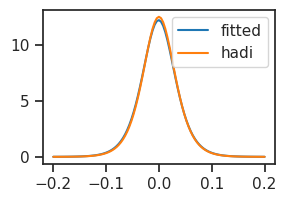

In [13]:
x = np.linspace(-0.2, 0.2, 101)
plt.plot(x, rv_fitted.pdf(x), label='fitted')
plt.plot(x, rv_hadi.pdf(x), label='hadi')
plt.legend()
plt.show()

In [15]:
samples_fitted = rv_fitted.rvs(size=len(data), random_state=0)
samples_hadi = rv_hadi.rvs(size=len(data), random_state=0)

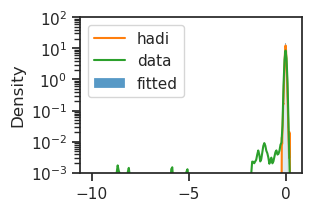

In [16]:
fig, ax = create_figure()
sns.histplot(samples_fitted, bins=100, label='fitted', color='C0', stat='density', ax=ax)
sns.kdeplot(samples_hadi, label='hadi', color='C1', ax=ax)
sns.kdeplot(data, label='data', color='C2', ax=ax)
ax.legend()
ax.set(yscale='log', ylim=(0.001, 100))
plt.show()

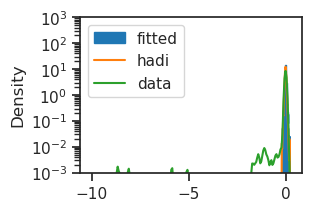

In [18]:
fig, ax = create_figure()
sns.histplot(samples_fitted, bins=100, label='fitted', color='C0', alpha=1.0, element='step', stat='density', ax=ax)
sns.kdeplot(samples_hadi, label='hadi', color='C1', ax=ax)
sns.kdeplot(data, label='data', color='C2', ax=ax)
ax.legend()
ax.set(yscale='log', ylim=(0.001, 1000))
plt.show()

In [139]:
p_fitted = f.fitted_param['genlogistic']
print(p_fitted)

(0.12439407299940793, 0.00883813760308141, 0.0034937326647490417)

In [171]:
p_hadi = (0.1, 0.01, 0.005)
rv_hadi = sp_stats.genlogistic(*p_hadi)
samples_hadi = rv_hadi.rvs(size=len(data), random_state=0)

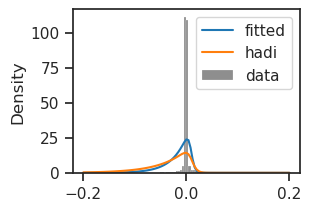

In [172]:
fig, ax = create_figure()
x = np.linspace(-0.2, 0.2, 101)
sns.histplot(data, bins=x, label='data', stat='density', color='dimgrey', ax=ax)
ax.plot(x, rv_fitted.pdf(x), label='fitted')
ax.plot(x, rv_hadi.pdf(x), label='hadi')
ax.legend()
plt.show()

In [198]:
sss  = sp_stats.genlogistic

In [200]:
class Initializer:
	def __init__(self, dist: str, **kwargs):
		try:
			dist = getattr(dists, dist)
			kwargs = filter_kwargs(dist, kwargs)
		except AttributeError:
			dist = getattr(sp_stats, dist)
			self.scipy = True
		self.dist = dist(**kwargs)

	@torch.inference_mode()
	def apply(self, weight: torch.Tensor):
		if self.scipy:
			values = self.dist.rvs(tuple(weight.shape))
			values = torch.tensor(values, dtype=torch.float)
		else:
			values = self.dist.sample(weight.shape)
		weight.data.copy_(values.to(weight.device))
		return

In [204]:
kws = dict(c=0.1, loc=0.01, scale=0.005)
init = Initializer('genlogistic', **kws)

In [205]:
layer = nn.Linear(10, 4 * 256)
init.apply(layer.weight)

<Axes: ylabel='Count'>

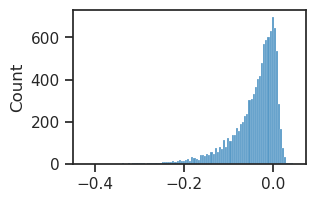

In [206]:
sns.histplot(tonp(layer.weight).ravel(), bins=100)

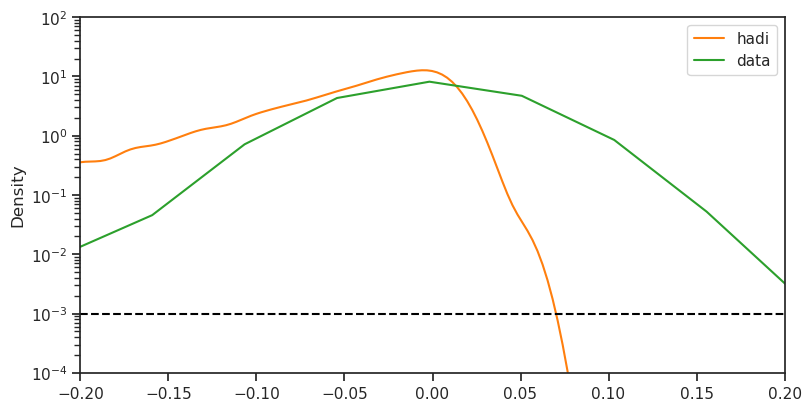

In [164]:
fig, ax = create_figure(figsize=(8, 4))
sns.kdeplot(samples_hadi, label='hadi', color='C1', ax=ax)
sns.kdeplot(data, label='data', color='C2', ax=ax)
ax.axhline(1e-3, color='k', ls='--')
ax.set(yscale='log', ylim=(1e-4, 1e2), xlim=(-0.2, 0.2))
ax.legend()
plt.show()

In [38]:
class GeneralizedLogistic(dists.Distribution):
    def __init__(self, shape, loc, scale):
        super(GeneralizedLogistic, self).__init__()
        self.a = shape
        self.b = loc
        self.c = scale

    def log_prob(self, value):
        exp_term = torch.exp(-self.b * (value - self.c))
        denom = (1 + exp_term) ** (1 + self.a)
        log_prob = torch.log(self.a) + torch.log(self.b) - self.b * (value - self.c) - (1 + self.a) * torch.log(denom)
        return log_prob

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape)
        # Inverse transform sampling
        x = self.c - torch.log((1/u - 1) ** (1/self.a) - 1) / self.b
        return x


In [39]:
d = GeneralizedLogistic(*params)

/home/hadi/anaconda3/lib/python3.11/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.GeneralizedLogistic'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [40]:
d.sample((100, ))

tensor([-1343.3613,        nan,  -808.8788, -1395.3477,        nan,  -353.8529,
               nan,  -895.3619,        nan, -1321.7845,        nan,        nan,
               nan,        nan,        nan,        nan,  -842.0922, -1501.5183,
               nan,  -420.7154,  -289.7043,  -449.0042,  -219.1582, -1053.8844,
         -301.0729,        nan, -2050.8328,        nan,        nan,  -807.2089,
               nan,        nan, -2395.8560,   -86.2984,        nan, -1262.3876,
               nan,        nan,        nan,        nan,        nan,        nan,
         -928.2094,        nan,        nan,        nan,        nan, -1249.9264,
        -2479.9407, -1236.9242,  -601.6499, -1781.8079,        nan,  -192.5150,
        -4252.0615,        nan,        nan, -1276.2260, -1049.6963,        nan,
               nan, -1867.9564,        nan, -4207.7007,  -553.2851,        nan,
         -460.6216,        nan,        nan,        nan,    13.0022, -1324.4888,
         -841.9484, -1223.2595, -1257.24

In [43]:
getattr(sp_stats, 'genlogistic')

In [44]:
params

(0.12439407299940793, 0.00883813760308141, 0.0034937326647490417)

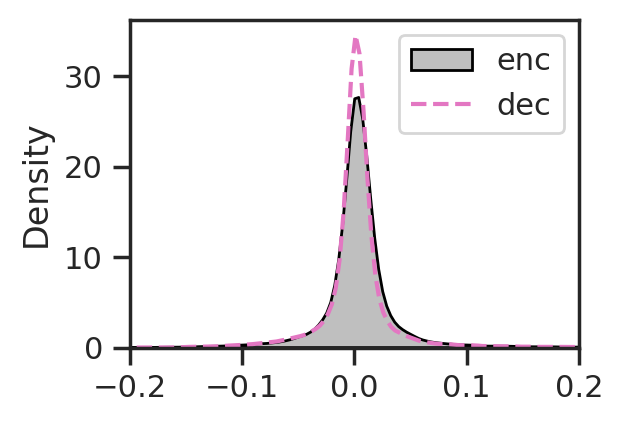

In [4]:
fig, ax= create_figure(dpi=200)
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.2, 0.2))
add_legend(ax)
plt.show()

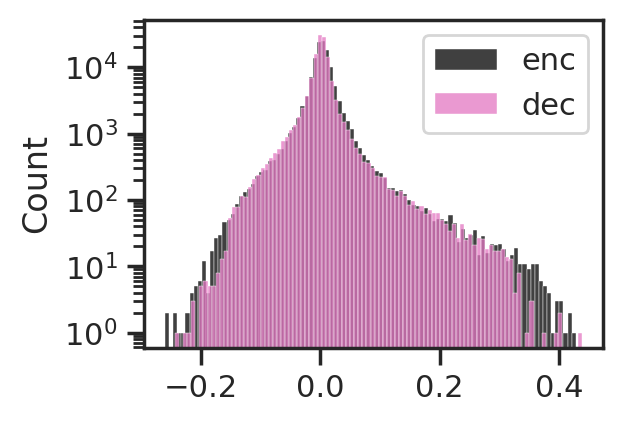

In [5]:
fig, ax= create_figure(dpi=200)
sns.histplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', bins=100, ax=ax)
sns.histplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', bins=100, ax=ax)
ax.set(yscale='log')
add_legend(ax)
plt.show()

In [6]:
tr, meta = load_model(
    'poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>',
    'klconst0.01_gradx3-StudentTScale0.1_mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_07,05:46)',
    device=device,
)
data, loss, etc = tr.validate()

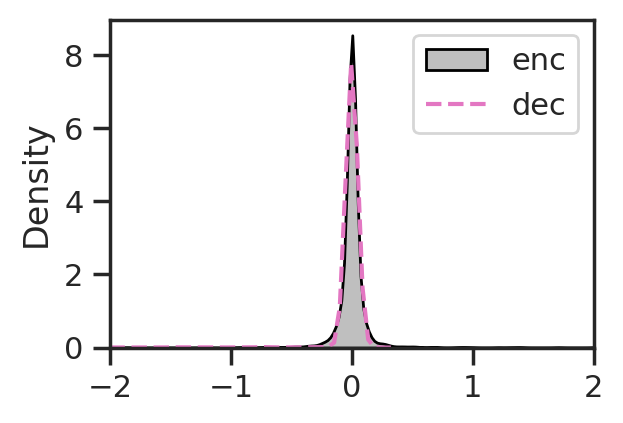

In [7]:
fig, ax= create_figure(dpi=200)
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-2, 2))
add_legend(ax)
plt.show()

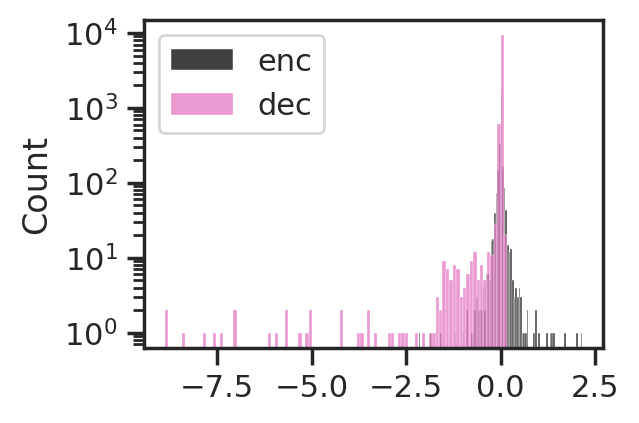

In [8]:
fig, ax= create_figure(dpi=200)
sns.histplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', bins=100, ax=ax)
sns.histplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', bins=100, ax=ax)
ax.set(yscale='log')
add_legend(ax)
plt.show()

In [37]:
layer_df2 = nn.Linear(256, 10)
layer_df3 = nn.Linear(256, 10)

init_df2 = Initializer('StudentT', scale=0.1, df=2)
init_df2.apply(layer_df2.weight)

init_df3 = Initializer('StudentT', scale=0.1, df=3)
init_df3.apply(layer_df3.weight)

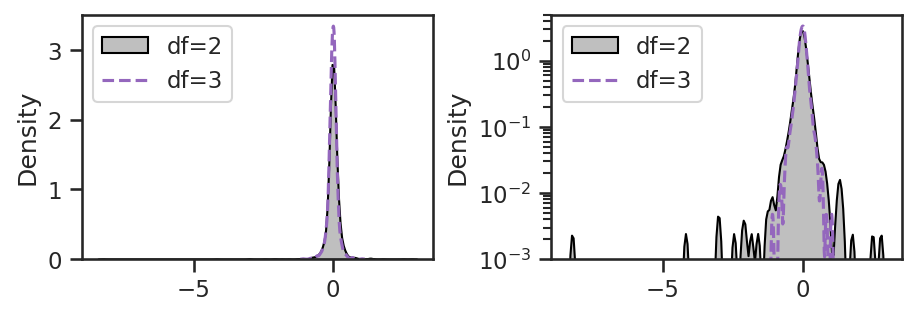

In [50]:
fig, axes = create_figure(1, 2, dpi=150, cnst=True)
for ax in axes.flat:
    sns.kdeplot(tonp(layer_df2.weight).ravel(), color='k', label='df=2', fill=True, ax=ax)
    sns.kdeplot(tonp(layer_df3.weight).ravel(), color='C4', label='df=3', ls='--', ax=ax)
axes[1].set(yscale='log', ylim=(0.001, 5))
add_legend(axes)
plt.show()

In [7]:
print(vars(tr.cfg))

{
    'lr': 0.005,
    'epochs': 3000,
    'batch_size': 1000,
    'warm_restart': 0,
    'warmup_epochs': 5,
    'optimizer': 'adamax_fast',
    'optimizer_kws': {'weight_decay': 0.0, 'betas': [0.9, 0.999], 'eps': 1e-08},
    'scheduler_type': 'cosine',
    'scheduler_kws': {'T_max': 2995.0, 'eta_min': 1e-05},
    'ema_rate': 0.999,
    'grad_clip': 500,
    'chkpt_freq': 50,
    'eval_freq': 20,
    'log_freq': 10,
    'use_amp': False,
    'method': 'mc',
    'kl_beta': 1.0,
    'kl_beta_min': 0.0001,
    'kl_anneal_cycles': 0,
    'kl_anneal_portion': 0.5,
    'kl_const_portion': 0.001,
    'lambda_anneal': False,
    'lambda_init': 0.0,
    'lambda_norm': 0.0,
    'temp_anneal_portion': 1.0,
    'temp_anneal_type': 'exp',
    'temp_start': 1.0,
    'temp_stop': 0.05
}

In [4]:
list(tr.stats)

['grad',
 'lr',
 't',
 'eval/mse',
 'eval/kl',
 'eval/kl_diag',
 'sprs/%-zero',
 'sprs/lifetime',
 'sprs/population']

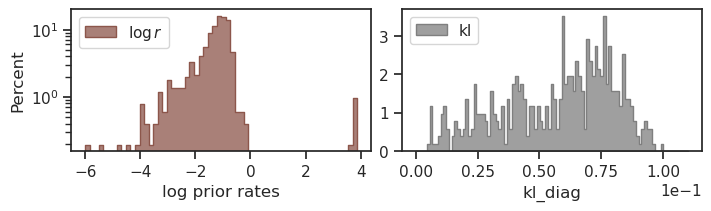

In [5]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(tonp(tr.model.log_rate.squeeze()), label=r'$\log r$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

add_legend(axes, loc='upper left')
axes[0].set(xlabel='log prior rates', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='linear')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

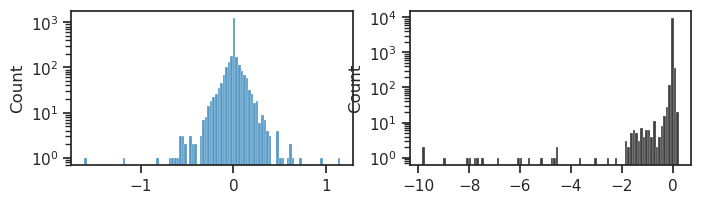

In [6]:
w_enc = tonp(tr.model.fc_enc.weight)
w_dec = tonp(tr.model.fc_dec.weight)

fig, axes = create_figure(1, 2, (8, 2))
sns.histplot(w_enc.ravel(), ax=axes[0], bins=100)
sns.histplot(w_dec.ravel(), ax=axes[1], bins=100, color='k')
axes[0].set(yscale='log')
axes[1].set(yscale='log')
plt.show()

In [3]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
cfg_vae['init_dist'] = 'StudentT'
cfg_vae['init_scale'] = 0.1

print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_ch': 32, 'n_latents': 10, 'prior_clamp': -2.0, 'prior_log_dist': 'uniform', 'rmax_q': 1.0, 
'fit_prior': True, 'enc_type': 'conv', 'dec_type': 'conv', 'enc_bias': True, 'dec_bias': True, 'init_dist': 
'StudentT', 'init_scale': 0.1}

Trainer:
{'lr': 0.002, 'epochs': 1200, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 
'grad_clip': 1000}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  6.2 Mil   |
|     ---     |    ---     |
|     stem    |    352     |
|     enc     |  4.9 Mil   |
|    fc_enc   |   2.6 K    |
|    fc_dec   |   11.3 K   |
|     dec     |  1.2 Mil   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>
mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_07,05:46)

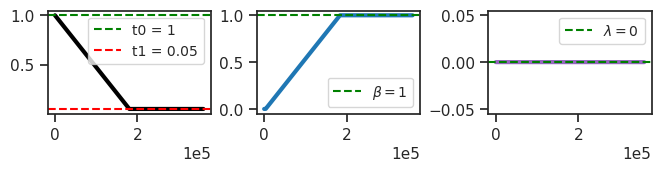

In [4]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

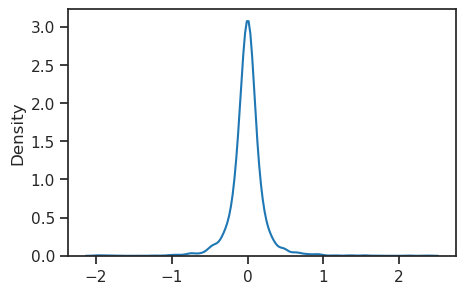

In [5]:
sns.kdeplot(tonp(vae.fc_enc.weight.data.ravel()));

In [ ]:
comment = f"klconst{tr.cfg.kl_const_portion}_gradx3-{vae.cfg.init_dist}Scale{vae.cfg.init_scale}_{tr.cfg.name()}"
# comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 960, avg loss: 34.986939:  80%|███████████████████▏    | 959/1200 [2:49:25<41:36, 10.36s/it]

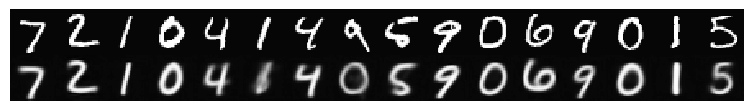

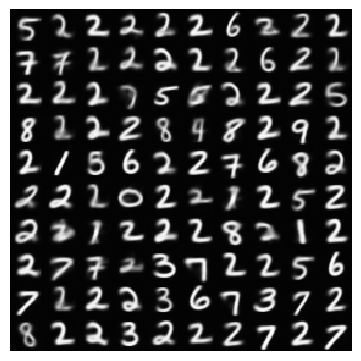

In [7]:
tr.show_recon(0.0), tr.show_samples(0.0);

In [8]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 27.745663, 'kl': 8.764686, 'kl_diag': 0.87646854, 'tot': 36.51035}

In [9]:
df, df_summary = knn_analysis(
    x=etc['log_dr'],
    y=tonp(tr.dl_vld.dataset.tensors[1]),
    n_iter=100,
    verbose=True,
)

train sample size: 20, iter #0:   0%|                             | 0/801 [00:00<?, ?it/s]/home/hadi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hadi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hadi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [10]:
df_summary

,mean,std
size,,
20,0.366050,0.051699
50,0.599798,0.055298
100,0.748202,0.035225
200,0.846716,0.020189
500,0.907612,0.008116
1000,0.931420,0.005280
2000,0.945220,0.004200
4000,0.956846,0.001636
5000,0.958200,NaN
